## Implementing AlexNet

From [Wikipedia](https://en.wikipedia.org/wiki/AlexNet):

AlexNet is the name of a convolutional neural network (CNN) architecture, designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton, who was Krizhevsky's Ph.D. advisor.

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The 
original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) 
during training.


### Implementation Details

#### Python Libraries
- Pytorch
- Torchvision, Torchtext (For download utilities)
- TorchInfo (for summarizing models)
- Numpy
- Matplotlib
- Seaborn

#### Dataset Used
- [Kaggle Cats and Dogs Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

#### References
- [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) (Original Paper)
- [Understanding AlexNet: A Detailed Walkthrough](https://towardsdatascience.com/understanding-alexnet-a-detailed-walkthrough-20cd68a490aa) (Towards Data Science Article)

#### Implementation Result
- **Number of Training Epoch :** 20

- **Best Test Loss :** 0.2918
- **Best Test Accuracy :** 86.93%

In [1]:
%config Completer.use_jedi = False

In [2]:
import os

import torch
import torch.nn as nn


from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F_vision
import torch.nn.functional as F

import numpy as np

from torchtext.utils import download_from_url, extract_archive
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import matplotlib.pyplot as plt
from torchinfo import summary



### Preparing the data and Data Cleaning
- Let's create a helper function first for creating directories
- Then let's choose a `download_root` for our dataset where we would download and unpack, Kaggle's Cat and Dogs dataset
- You can change `download_root` if you want to. It should programatically still setup the dataset directories for you.

In [3]:
def make_dir(target_dir):
    if not os.path.isdir(target_dir):
        os.mkdir(target_dir)

In [4]:
download_root = '../dataset/'
download_path = os.path.join(download_root, 'cats_vs_dogs.zip')
cats_dog_uri = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
dataset_folder = os.path.join(download_root, 'cats_vs_dogs')

In [91]:
make_dir(download_root)

In [5]:
download_from_url(cats_dog_uri, download_path)

100%|██████████| 825M/825M [03:14<00:00, 4.24MB/s] 


'/home/jums/speedrun/dataset/cats_vs_dogs.zip'

In [6]:
extract_archive(download_path, dataset_folder)

['../dataset/cats_vs_dogs/PetImages/Cat/0.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/1.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/100.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/1000.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10000.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10001.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10002.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10003.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10004.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10005.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10006.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10007.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10008.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10009.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/1001.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10010.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10011.jpg',
 '../dataset/cats_vs_dogs/PetImages/Cat/10012.jpg',
 '../dataset/cats_vs_dogs/P

### Initializing directories
- I would want to cache my dataset first since most of these images varies on different sizes and some image JPGs are corrupt.
- Basically, I want to initialize my directories with this particular directory format...

```
dataset/
└── cats_vs_dogs
    ├── PetImages  # Source Dataset
    │   ├── Cat
    │   └── Dog
    └── resized    # Initial Preprocessed/Cached Dataset
        ├── test
        │   ├── Cat
        │   └── Dog
        └── train
            ├── Cat
            └── Dog

```
- The next code below will initialize the `Source Dataset` to the `Initial Prepocessed/Cached Dataset`

In [7]:
dataset_source = os.path.join(dataset_folder, 'PetImages')

dataset_resized = os.path.join(dataset_folder, 'resized')
dataset_train = os.path.join(dataset_resized, 'train')
dataset_test = os.path.join(dataset_resized, 'test')

make_dir(dataset_resized)
make_dir(dataset_train)
make_dir(dataset_test)

In [8]:
train_cat_dir = os.path.join(dataset_train, 'Cat')
train_dog_dir = os.path.join(dataset_train, 'Dog')

test_cat_dir = os.path.join(dataset_test, 'Cat')
test_dog_dir = os.path.join(dataset_test, 'Dog')

make_dir(train_cat_dir)
make_dir(train_dog_dir)

make_dir(test_cat_dir)
make_dir(test_dog_dir)

In [9]:
cat_src_dir = os.path.join(dataset_source, 'Cat')
dog_src_dir = os.path.join(dataset_source, 'Dog')

print(cat_src_dir)
print(dog_src_dir)

../dataset/cats_vs_dogs/PetImages/Cat
../dataset/cats_vs_dogs/PetImages/Dog


In [10]:
from PIL import Image
from random import shuffle


def list_paths(target_dir):
    fnames = os.listdir(target_dir)
    return [os.path.join(target_dir, fn) for fn in fnames if fn.endswith('.jpg')]


def generate_dst(src, target_dir):
    
    parent_dir = src.split(os.sep)[-2]
    fname = src.split(os.sep)[-1]
    
    if parent_dir == 'Cat':
        return os.path.join(target_dir, 'Cat', fname)
    else:
        return os.path.join(target_dir, 'Dog', fname)
        


def create_train_test_paths(file_paths, train_dir, test_dir, train_split=0.9):
    
    fps_copy = file_paths.copy()
    
    shuffle(fps_copy)
    
    total = len(fps_copy)
    train_len = int(total * train_split)
    
    srcs_train = fps_copy[0:train_len]
    srcs_test = fps_copy[train_len:]
    
    
    dsts_train = [generate_dst(src, train_dir) for src in srcs_train]
    dsts_test = [generate_dst(src, test_dir) for src in srcs_test]
    
    src_paths = srcs_train + srcs_test
    dst_paths  = dsts_train + dsts_test
    
    return src_paths, dst_paths
    
    
    
def resize_image_file(src, dst, target_size=256):
    
    with Image.open(src) as img:
        im_resized = img.resize((target_size, target_size))
        im_resized.save(dst)
        
        

def acquire_train_test(cats_dir, dogs_dir, train_dir, test_dir, 
                       train_split=0.9):
    cat_img_src_paths = list_paths(cats_dir)
    dog_img_src_paths = list_paths(dogs_dir)
    

    raw_src_paths = cat_img_src_paths + dog_img_src_paths
    
    img_src_paths, img_dst_paths = create_train_test_paths(raw_src_paths, 
                                                           train_dir,
                                                           test_dir)
    
    assert len(img_src_paths) == len(img_dst_paths), 'Mismatch on src and dst of filepaths.'
    
    total_images = len(img_src_paths)
    
    for idx, sd in enumerate(zip(img_src_paths, img_dst_paths)):
        try:
            resize_image_file(sd[0], sd[1])
            
            if idx % 1000 == 0:
                print(f'[{idx}/{total_images}] Resizing from {sd[0]} to {sd[1]} success.')
        
        except:
            print(f'[{idx}/{total_images}] Resizing from {sd[0]} to {sd[1]} failed.')
        
        if os.path.isfile(sd[1]):
            if os.path.getsize(sd[1]) == 0:
                # Discarding zero byte file
                print(f'[{idx}/{total_images}] Removing zero-byte file {sd[1]}')
                os.remove(sd[1])
            
            

    

### Note:
- The function `acquire_train_test` simply takes the source cat and dog directory images.
- Basically, it just resizes the images to `(256x256)` and discard corrupt JPGs (files with zero bytes)

### Another Note:
- You'll notice that there are many messages with `Resizing from <src_file> to <dst_file> failed`, this is expected since there are multiple images that are corrupt.
- Basically, this is just part of Data Cleaning Process.

In [11]:
acquire_train_test(cat_src_dir, dog_src_dir, dataset_train, dataset_test)

[0/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/733.jpg to ../dataset/cats_vs_dogs/resized/train/Cat/733.jpg success.
[279/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/6059.jpg to ../dataset/cats_vs_dogs/resized/train/Dog/6059.jpg failed.
[279/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Dog/6059.jpg
[472/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/9565.jpg to ../dataset/cats_vs_dogs/resized/train/Cat/9565.jpg failed.
[472/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Cat/9565.jpg
[1000/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/12376.jpg to ../dataset/cats_vs_dogs/resized/train/Dog/12376.jpg success.
[1167/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/4367.jpg to ../dataset/cats_vs_dogs/resized/train/Dog/4367.jpg failed.
[1167/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Dog/4367.jpg
[1399/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/

/home/jums/miniconda3/envs/pt/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[9651/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/11285.jpg to ../dataset/cats_vs_dogs/resized/train/Dog/11285.jpg failed.
[9651/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Dog/11285.jpg
[10000/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/3856.jpg to ../dataset/cats_vs_dogs/resized/train/Cat/3856.jpg success.
[10652/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/11849.jpg to ../dataset/cats_vs_dogs/resized/train/Dog/11849.jpg failed.
[10652/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Dog/11849.jpg
[10749/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/10820.jpg to ../dataset/cats_vs_dogs/resized/train/Cat/10820.jpg failed.
[10749/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/train/Cat/10820.jpg
[11000/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/740.jpg to ../dataset/cats_vs_dogs/resized/train/Cat/740.jpg success.
[11364/25000] Resizing from ../dataset/ca

[22993/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/5370.jpg to ../dataset/cats_vs_dogs/resized/test/Cat/5370.jpg failed.
[22993/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/test/Cat/5370.jpg
[23000/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/8881.jpg to ../dataset/cats_vs_dogs/resized/test/Dog/8881.jpg success.
[23930/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/666.jpg to ../dataset/cats_vs_dogs/resized/test/Cat/666.jpg failed.
[24000/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/10267.jpg to ../dataset/cats_vs_dogs/resized/test/Dog/10267.jpg success.
[24320/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Dog/9188.jpg to ../dataset/cats_vs_dogs/resized/test/Dog/9188.jpg failed.
[24320/25000] Removing zero-byte file ../dataset/cats_vs_dogs/resized/test/Dog/9188.jpg
[24609/25000] Resizing from ../dataset/cats_vs_dogs/PetImages/Cat/4833.jpg to ../dataset/cats_vs_dogs/resized/test/Cat/4833.jpg failed.
[24609

### Data Augmentation

- I made two distinct transformation pipeline one with training data `train_transforms`, and one with test data `test_transforms`
- The reasoning for this is to test directly with undistorted images.

In [13]:
train_transforms = transforms.Compose([

    transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(
        [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                saturation=0.2, hue=0.1)],
        p=0.8
    ),
    
    transforms.ToTensor(),

])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

/home/jums/miniconda3/envs/pt/lib/python3.8/site-packages/torchvision/transforms/transforms.py:852: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


### Note on Data Augmentation VS The Original Implementation
- The original paper of [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) uses two Data Augmentation - The first one uses random cropping and random horizonal flips, the second one uses **Fancy PCA**.
- I've retained the first augmentation, and replaced the second with Color Jittering. The reason for doing this is for simplicity purposes. **Fancy PCA** isn't widely adopted, as evident with its absence with popular Deep Learning frameworks such as Pytorch and Tensorflow and other 3rd Party Libraries.

### Handling Label Type

I've also introduced a function for transforming the target Tensors. Since by default `ImageFolder` produces a target with datatype of `torch.int64`. The loss function of Pytorch for Binary CrossEntropy Loss `nn.BCELoss()` accepts `torch.float32` as arguments. Hence, we need to cast the datatype of the target.

In [14]:
def convert_type(y):
    return torch.tensor(y, dtype=torch.float32)

### Initializing the Dataset and Dataloader


In [81]:
tr_ds = ImageFolder(dataset_train, transform=train_transforms, target_transform=convert_type)
ts_ds = ImageFolder(dataset_test, transform=test_transforms, target_transform=convert_type)


tr_dl = DataLoader(tr_ds, batch_size=32, shuffle=True)
ts_dl = DataLoader(ts_ds, batch_size=32, shuffle=True)

### Let's check if the DataLoader is acquiring the right image data by visualizing an arbitrary Tensor

In [92]:
X,y = next(iter(ts_dl))

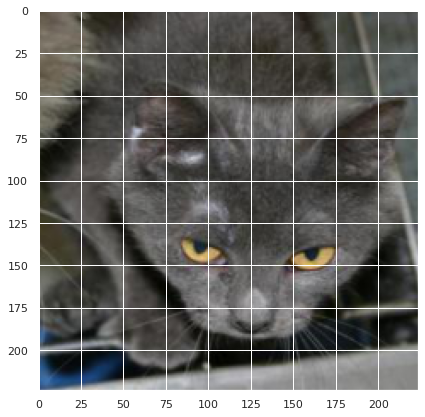

In [93]:
plt.imshow(X[1,:,:,:].permute(1, 2, 0))

In [18]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F_vision.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Overview with AlexNet Architecture

The reference for **AlexNet Details** and **AlexNet Architecture** image can be found on this article for Towards Data Science: [**Understanding AlexNet: A Detailed Walkthrough**](https://towardsdatascience.com/understanding-alexnet-a-detailed-walkthrough-20cd68a490aa) 

### AlexNet Details

```
    Layer C1: Convolution Layer (96, 11×11)
    Layer S2: Max Pooling Layer (3×3)
    Layer C3: Convolution Layer (256, 5×5)
    Layer S4: Max Pooling Layer (3×3)
    Layer C5: Convolution Layer (384, 3×3)
    Layer C6: Convolution Layer (384, 3×3)
    Layer C7: Convolution Layer (256, 3×3)
    Layer S8: Max Pooling Layer (3×3)
    Layer F9: Fully-Connected Layer (4096)
    Layer F10: Fully-Connected Layer (4096)
    Layer F11: Fully-Connected Layer (1000)
```

### AlexNet Architecture

![AlexNet](images/alexnet_archi.png)


#### Which Produces the Similar Output from the Implemented Model

```
1.  Conv L1        :  torch.Size([32, 96, 55, 55])
2.  Max Pool L2    :  torch.Size([32, 96, 27, 27])
3.  Conv L3        :  torch.Size([32, 256, 27, 27])
4.  Max Pool L4    :  torch.Size([32, 256, 13, 13])
5.  Conv L5        :  torch.Size([32, 384, 13, 13])
6.  Conv L6        :  torch.Size([32, 384, 13, 13])
7.  Conv L7        :  torch.Size([32, 256, 13, 13])
8.  Conv L8        :  torch.Size([32, 256, 6, 6])
9.  Flatten L9     :  torch.Size([32, 4096])
10. Flatten L10    :  torch.Size([32, 4096])
11. Output Layer   :  torch.Size([32, 1])
```

#### Model Summary:

```
=================================================================
Layer (type:depth-idx)                   Param #
=================================================================
AlexNet                                  --
├─Conv2d: 1-1                            34,944
├─MaxPool2d: 1-2                         --
├─BatchNorm2d: 1-3                       192
├─Conv2d: 1-4                            614,656
├─MaxPool2d: 1-5                         --
├─BatchNorm2d: 1-6                       512
├─Conv2d: 1-7                            885,120
├─BatchNorm2d: 1-8                       768
├─Conv2d: 1-9                            1,327,488
├─BatchNorm2d: 1-10                      768
├─Conv2d: 1-11                           884,992
├─BatchNorm2d: 1-12                      512
├─MaxPool2d: 1-13                        --
├─Flatten: 1-14                          --
├─Dropout: 1-15                          --
├─Linear: 1-16                           37,752,832
├─BatchNorm1d: 1-17                      8,192
├─Dropout: 1-18                          --
├─Linear: 1-19                           16,781,312
├─BatchNorm1d: 1-20                      8,192
├─Linear: 1-21                           4,097
=================================================================
Total params: 58,304,577
Trainable params: 58,304,577
Non-trainable params: 0
=================================================================
```

### Pytorch Implementation of AlexNet
- This is AlexNet implemented with certain few twists
- I've added few Batch-Normalization layers `nn.BatchNormd2d` in order to mitigate [**Vanishing Gradients**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), since it was initially observed when I've tried using the vanilla version of AlexNet

In [23]:
class AlexNet(nn.Module):
    
    def __init__(self, drop_out=0.1):
        super(AlexNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3,96, kernel_size=11, stride=4, padding=2)
        self.mp2 = nn.MaxPool2d(3, stride=2)
        self.bn1 = nn.BatchNorm2d(96)
        
        self.conv3 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.mp4 = nn.MaxPool2d(3, stride=2)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        
        self.conv6 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        
        self.conv7 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        
        
        self.mp8 = nn.MaxPool2d(3, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.d1 = nn.Dropout(p=drop_out)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.bn_fc1 = nn.BatchNorm1d(4096)
        
        self.d2 = nn.Dropout(p=drop_out)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn_fc2 = nn.BatchNorm1d(4096)
        
        self.fc3 = nn.Linear(4096, 1)

    
    def forward_train(self, func, x):
        if self.training:
            return func(x)
        
        return x
       
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.mp2(x)
        x = self.bn1(x)
        
        x = F.relu(self.conv3(x))        
        x = self.mp4(x)
        x = self.bn2(x)
        
        x = F.relu(self.conv5(x))
        x = self.bn3(x)
        
        x = F.relu(self.conv6(x))
        x = self.bn4(x)
        
        x = F.relu(self.conv7(x))
        x = self.bn5(x)
        
        x = self.mp8(x)
        x = self.flatten(x)
        
        x = self.forward_train(self.d1, x)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        
        x = self.forward_train(self.d2, x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        

        x = torch.sigmoid(self.fc3(x))    
        x = torch.squeeze(x)

        return x

In [24]:
model = AlexNet()

In [25]:
summary(model)

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Conv2d: 1-1                            34,944
├─MaxPool2d: 1-2                         --
├─BatchNorm2d: 1-3                       192
├─Conv2d: 1-4                            614,656
├─MaxPool2d: 1-5                         --
├─BatchNorm2d: 1-6                       512
├─Conv2d: 1-7                            885,120
├─BatchNorm2d: 1-8                       768
├─Conv2d: 1-9                            1,327,488
├─BatchNorm2d: 1-10                      768
├─Conv2d: 1-11                           884,992
├─BatchNorm2d: 1-12                      512
├─MaxPool2d: 1-13                        --
├─Flatten: 1-14                          --
├─Dropout: 1-15                          --
├─Linear: 1-16                           37,752,832
├─BatchNorm1d: 1-17                      8,192
├─Dropout: 1-18                          --
├─Linear: 1-19                           16,781,312
├─BatchNorm1d: 1-20  

### Adding an Accuracy Metric
- Adding a direct implementation for `accuracy` since it's straightforward to implement
- While we can use sklearn's implementation, it's much better to directly compute on Pytorch, since sklearn's implementation directly uses numpy `np.Array`.

In [26]:
def accuracy_metric(target, prediction, thresh=0.5):
    
    pred_round = torch.where(prediction > thresh, 1.0, 0.0)
    res = (target == pred_round).to(torch.int32)
    
    return torch.sum(res) / res.shape[0]
    

In [27]:
# Testing Accuracy Metric
x = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0])
y = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0])

accuracy_metric(y,x)

tensor(1.)

### Initialize available device
This initializes your Model and data to be used on GPU

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Note:
- We set our loss as Binary Crossentropy since our dataset is a Binary Classification problem.
- We used Adam as our optimizer since this produces decent results generally.

In [29]:
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)


In [30]:
model_root = '../model'
model_dir = os.path.join(model_root, 'alexnet')
model_file_path = os.path.join(model_dir, 'alexnet.pt')

make_dir(model_root)
make_dir(model_dir)

### Coding the Training Loop
- Here's the implementation of Training Loop
- While it seems lengthy, this is just your typical *Quick and Dirty Implementation* since I want to emulate Keras' fit functionality with Early Stopping. Though I won't use this kind of code in production.
- We can also use third-party libraries such as `Pytorch-Lightning` to remove the boilerplate code, but I want to ignore it for now.

In [31]:
import pandas as pd

def compile_history(epoch_list, 
                    train_loss_per_epoch, 
                    train_accuracy_per_epoch,
                    test_loss_per_epoch,
                    test_accuracy_per_epoch):
    
    json_list = []
    
    for epoch, train_loss, train_acc, test_loss, test_acc in zip(epoch_list,
                                                                 train_loss_per_epoch,
                                                                 train_accuracy_per_epoch,
                                                                 test_loss_per_epoch,
                                                                 test_accuracy_per_epoch):
        
        json_list.append({
            'epoch' : epoch,
            'train_loss' : train_loss,
            'train_acc' : train_acc,
            'test_loss' : test_loss,
            'test_acc' : test_acc
        })
        
    return pd.DataFrame(json_list)




def train_model(model, 
                criterion, 
                optimizer,
                train_dataloader,
                test_dataloader,
                device, 
                model_path, 
                num_epoch=5,
                patience=5):
    
    
    print('Training Model for AlexNet')
    
    print('Device: ', device)
    print('Batch Size: ', train_dataloader.batch_size)
    print('Train Total Batches: ', len(train_dataloader))
    print('Test Total Batches: ', len(test_dataloader))
    print('Model Path: ', model_path)
    print('Number of Epochs: ', num_epoch)
    print('Patience: ', patience)
    print(' ')
    
    
    epoch_list = []
    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    
    test_loss_per_epoch = []
    test_accuracy_per_epoch = []
    
    total_train_batch = len(train_dataloader)
    total_test_batch = len(test_dataloader)
    
    patience_counter = 0
    
    for epoch in range(num_epoch):
        
        running_loss = 0.0
        running_acc = 0.0
        
        for i, data in enumerate(train_dataloader, start=1):
            X, yt = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            yp = model(X)
            
            loss = criterion(yp, yt)
            loss.backward()
            optimizer.step()
            
            running_acc += accuracy_metric(yt, yp).cpu().detach().numpy()
            running_loss += loss.item()
            
            ave_loss = running_loss / i
            ave_acc = running_acc / i
            
            print(f'epoch = {epoch + 1} [{i}/{total_train_batch}] Train Loss = {ave_loss} \tTrain Accuracy = {ave_acc}',
                  end='\r')
            
            
        print('')
        
        test_running_loss = 0.0
        test_running_acc = 0.0
        
        for i, data in enumerate(test_dataloader, start=1):
            
            X, yt = data[0].to(device), data[1].to(device)
        
            yp = model(X)    
            test_loss = criterion(yp, yt)
            
            test_running_acc += accuracy_metric(yt, yp).cpu().detach().numpy()
            test_running_loss += test_loss.item()

            test_ave_loss = test_running_loss / i
            test_ave_acc = test_running_acc / i

            
            print(f'epoch = {epoch + 1} [{i}/{total_test_batch}] Test Loss = {test_ave_loss}' + 
                  f' \tTest Accuracy = {test_ave_acc}',
                  end='\r')
            
        
        print('')
        
        tr_ave_loss = running_loss / total_train_batch
        ts_ave_loss = test_running_loss / total_test_batch
        
        tr_ave_acc = running_acc / total_train_batch
        ts_ave_acc = test_running_acc / total_test_batch
        
        
        epoch_list.append(epoch + 1)
        train_loss_per_epoch.append(tr_ave_loss)
        test_loss_per_epoch.append(ts_ave_loss)
        
        train_accuracy_per_epoch.append(tr_ave_acc)
        test_accuracy_per_epoch.append(ts_ave_acc)
        
        
        if np.max(test_accuracy_per_epoch) == test_accuracy_per_epoch[-1]:
            print(f'epoch = {epoch + 1} Saving best Model to path = {model_path}')
            torch.save(model, model_path )
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
            
        
    return compile_history(epoch_list,
                           train_loss_per_epoch,
                           train_accuracy_per_epoch,
                           test_loss_per_epoch,
                           test_accuracy_per_epoch)
        
    

In [32]:
num_epoch = 20
df_history = train_model(model, 
            criterion, 
            optimizer,
            tr_dl,
            ts_dl,
            device,
            model_file_path, num_epoch=num_epoch)

Training Model for AlexNet
Device:  cuda:0
Batch Size:  32
Train Total Batches:  702
Test Total Batches:  78
Model Path:  ../model/alexnet/alexnet.pt
Number of Epochs:  20
Patience:  5
 
epoch = 1 [702/702] Train Loss = 1.4081281027902566 	Train Accuracy = 0.5138295347194726
epoch = 1 [78/78] Test Loss = 0.8340278435976077 	Test Accuracy = 0.5141645987064413
epoch = 1 Saving best Model to path = ../model/alexnet/alexnet.pt
epoch = 2 [702/702] Train Loss = 0.7953045839427882 	Train Accuracy = 0.5272881054131054
epoch = 2 [78/78] Test Loss = 0.6739679414492387 	Test Accuracy = 0.5787453468029315
epoch = 2 Saving best Model to path = ../model/alexnet/alexnet.pt
epoch = 3 [702/702] Train Loss = 0.6841438281909693 	Train Accuracy = 0.5795198243397933
epoch = 3 [78/78] Test Loss = 0.641171028980842 	Test Accuracy = 0.63729063211343239
epoch = 3 Saving best Model to path = ../model/alexnet/alexnet.pt
epoch = 4 [702/702] Train Loss = 0.654036038876259 	Train Accuracy = 0.61921296296296299
epoc

In [33]:
df_history

,epoch,train_loss,train_acc,test_loss,test_acc
0,1,1.408128,0.513830,0.834028,0.514165
1,2,0.795305,0.527288,0.673968,0.578745
2,3,0.684144,0.579520,0.641171,0.637291
3,4,0.654036,0.619213,0.605966,0.670518
4,5,0.628357,0.648964,0.573930,0.696999
5,6,0.585445,0.690542,0.520230,0.735512
6,7,0.539529,0.728187,0.455847,0.788345
7,8,0.498700,0.752003,0.395340,0.814826
8,9,0.497003,0.752196,0.417516,0.804397
9,10,0.449597,0.781398,0.369227,0.841708


### Now for the Results

In [56]:
df_history.to_csv('../model/alexnet/train_history.csv', index=False)

In [73]:
import seaborn as sns
sns.set_theme(style='dark')
sns.set(rc = {'figure.figsize':(12,7)})
sns.set_palette('colorblind')

### Loss Going Downtrend

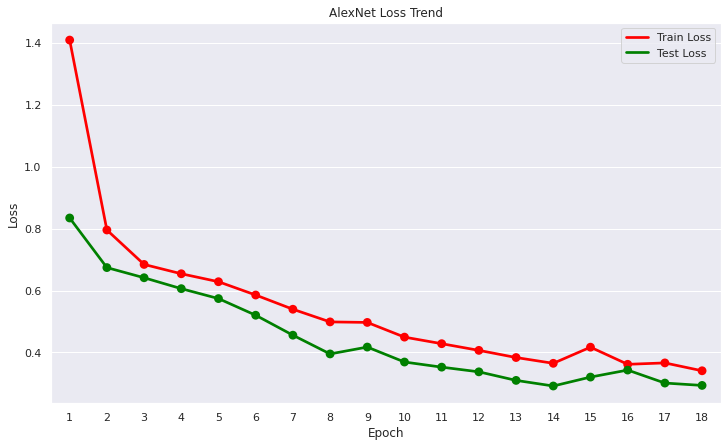

In [87]:
ax = sns.pointplot(x='epoch', y='train_loss', data=df_history, color='red',
                   label='Train Accuracy')

ax = sns.pointplot(x='epoch', y='test_loss', data=df_history, color='green', 
                   label='Test Accuracy')

ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('AlexNet Loss Trend')


ax.legend(handles=ax.lines[::len(df_history)+1], labels=['Train Loss', 'Test Loss'])

### Accuracy Going Up

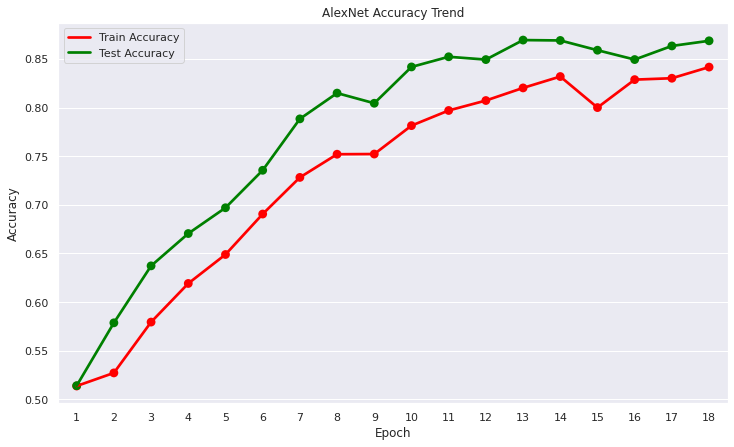

In [88]:
ax = sns.pointplot(x='epoch', y='train_acc', data=df_history, color='red',
                   label='Train Accuracy')

ax = sns.pointplot(x='epoch', y='test_acc', data=df_history, color='green', 
                   label='Test Accuracy')

ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set_title('AlexNet Accuracy Trend')

ax.legend(handles=ax.lines[::len(df_history)+1], labels=['Train Accuracy', 'Test Accuracy'])

### Notes on Results
- The best test result metrics are `test_loss = 0.2918` and `test_accuracy = 86.93`.
- This can be improved by using larger number of training epoch or other methods that can be used to squeeze performance like using a Learning Rate Scheduler or additional tweaks with the architecture.
- But for now, we'll stick with these results.
